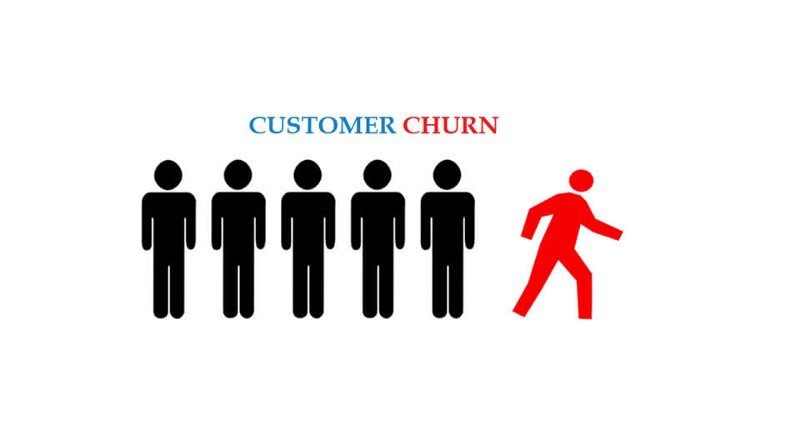

In [2]:
from IPython.display import Image,Markdown, display
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
Image(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\Telecom Churn Analysis\churn.jpg")

In [3]:
#Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
from scipy.stats import ttest_ind, pointbiserialr, chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from info_gain import info_gain
from sklearn.feature_extraction.image import grid_to_graph
from sklearn import tree, metrics
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import pydotplus
import seaborn as sns
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

c:\users\harish patlolla\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Functions to verify association among the variables statistically and visually

In [13]:

#Association between two categorical variables
def categorical_association(df, c1, c2):  
    #barchart
    sns.catplot(x=c2, col=c1, data=df, saturation=.5,kind="count",height=3, aspect=1)
    plt.show()
    #creating crosstabs to generate chi-square statistic
    data=pd.crosstab(df[c1],df[c2])
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    s, p, d, t=chi2_contingency(data.fillna(0))
    #caluclating cramerV to measure the strength of association between the variables
    chi2 = chi2_contingency(data.fillna(0))[0]
    n = data.values.sum()
    cramers_v=np.sqrt(chi2 / (n*(min(data.shape)-1)))
    
    if (p<0.05):
        print(color.BOLD+color.GREEN + 'There is association between '+str(c1) +' and  ' +str(c2))
        print('The strength of the assocation is '+str(round(cramers_v,2)))
    else:
        print(color.BOLD+color.RED +'There is no association between '+str(c1) +' and  ' +str(c2))
    print(' ')
    print(color.END+' ')
    return c1,round(cramers_v,2),round(p,4)

############################################################################################

#Association between two continuous variable

def continous_association(df,c1,c2):
    sns.boxplot(x=c1,y=c2,data=df)
    plt.title('Comparison of Average tenure between churned and not churned customers')
    plt.show()
    churn_sample=churn_data[churn_data[c1]=='Yes'][c2]
    nonchurn_sample=churn_data[churn_data[c1]=='No'][c2]
    t,p=ttest_ind(churn_sample,nonchurn_sample)
    continuous_data=churn_data[c2]
    binary_data=pd.DataFrame(churn_data[c1])
    binary_data.replace({'Churn':{'No':0,'Yes':1}},inplace=True)
    #biserialcorrelation
    pbc = pointbiserialr(continuous_data, binary_data[c1])[0]
    if (p<0.05):
        print(color.BOLD+color.GREEN + 'There is association between '+str(c1) +' and  ' +str(c2))
    else:
        print(color.BOLD+color.RED +'There is no association between '+str(c1) +' and  ' +str(c2))
    print('The strength of relation is '+str(round(pbc,2)))

    
#Creation of dummy variables
def dummy_variables_creation(df):
    
    #categorical columns list
    categorical_columns_list=df.select_dtypes(include=['object','category']).columns.to_list()
    #creating a backup
    final=df.copy()
    for i in categorical_columns_list:
        variable_name=str(i)+'_dummy'
        variable_name=pd.get_dummies(df[i], prefix=i)
        final=pd.concat([final,variable_name],axis=1)
    total_columns_list=final.columns.values.tolist()
    To_drop_variables=[i for i in total_columns_list if i  in categorical_columns_list]
    print(color.BOLD+color.RED+'The variables that are dropped as part of dummy creation')
    print(To_drop_variables)
    To_keep_variables=[i for i in total_columns_list if i not in categorical_columns_list]
    final=final[To_keep_variables]
    return(final)


In [4]:
#importing the data
os.chdir('D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\Telecom Churn Analysis')
churn_data=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 2: Pre-processing the data


    * Handling the missing values,Dropping the unnecessary columns
    * Type Casting
    * Exploratory Data Analysis 
    * Transforming the skewed variables
    * Dummy coding the categorical variables
    * Splitting the data

### Looking at the missing values in the data set

In [5]:
print(churn_data.isnull().sum().sort_values(ascending=False))

Churn               0
OnlineSecurity      0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineBackup        0
TotalCharges        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
customerID          0
dtype: int64


### Type Conversion 

In [6]:
print(churn_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#Replacing the values in the columns
churn_data.replace({'SeniorCitizen':{0:'No',1:'Yes'},
                    'MultipleLines':{'No phone service':'No'},
                    'OnlineSecurity':{'No internet service':'No'},
                    'OnlineBackup'  :{'No internet service':'No'},
                    'DeviceProtection':{'No internet service':'No'},
                    'TechSupport':{'No internet service':'No'},
                   'StreamingTV':{'No internet service':'No'},
                   'StreamingMovies':{'No internet service':'No'}},
                   inplace=True)

#replacing the blank values with null values
churn_data['TotalCharges'].replace(r'^\s*$','NaN', regex=True,inplace=True)

In [8]:
#There are 12(<1%) records in the data with TotalCharges as NaN
# we can either replace them / drop 
churn_data=churn_data[churn_data['TotalCharges']!='NaN']

#typecasting the Total Charges column to float
churn_data['TotalCharges']=churn_data['TotalCharges'].astype(float)

In [9]:
#dropping customerID columns
churn_data.drop(columns=['customerID'],inplace=True)

In [10]:
#splitting the columns into numerical and categorical columns

numeric_cols_data=churn_data.select_dtypes(include=['int64','float64'])
print(color.RED+color.BOLD+'The quantitative variables are')
print(numeric_cols_data.columns)

print('')
print('#####################################################')
print('')

categorical_cols_data=churn_data.select_dtypes(include=['object'])
print(color.GREEN +color.BOLD+ 'The qualitative variables are')
print(categorical_cols_data.columns)


The quantitative variables are
Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

#####################################################

The qualitative variables are
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'], dtype='object')


# Exploratory Data Analysis

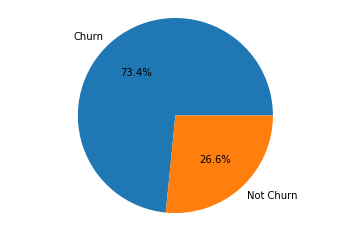

This is a class imbalance problem , which will be later handled using sampling techiques


In [11]:
# Looking at the values of Yes and No's in the target variable CHURN
labels = ['Churn','Not Churn']
sizes = [churn_data['Churn'].value_counts()[0],churn_data['Churn'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()
plt.show()
print(color.BOLD+'This is a class imbalance problem , which will be later handled using sampling techiques')

### Categorical Variables

    Checking the  associations between the target and the categorical predictors

#### Chi-Square test of Independence

https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/chi-square/

    Chi-square test for independence compares two variables in a contingency table to see if they are related. In a more general sense,  it tests to see whether distributions of categorical variables differ from each another.A very small chi square test statistic means that your       observed data fits your expected data extremely well. In other words, there is a relationship.A very large chi square test statistic means that the data does not fit very well.   In other words, there isn’t a relationship.

#### Information Gain
    Information gain can also be used for feature selection, by evaluating the gain of each variable in the context of the target variable. Higher the Information gain, better the variable is, in discriminating the classes in the target

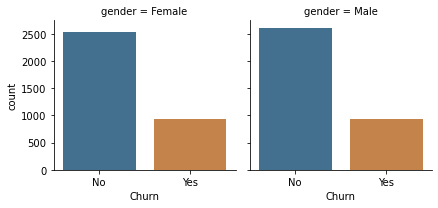

There is no association between gender and  Churn
 
 


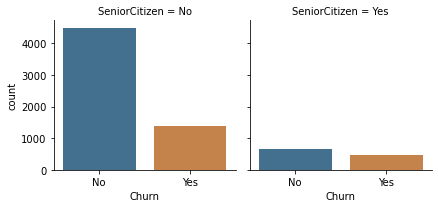

There is association between SeniorCitizen and  Churn
The strength of the assocation is 0.15
 
 


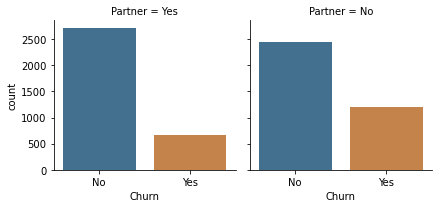

There is association between Partner and  Churn
The strength of the assocation is 0.15
 
 


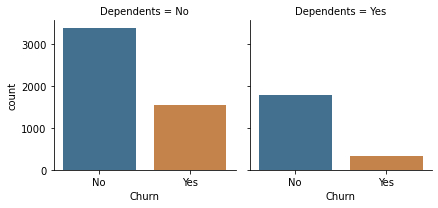

There is association between Dependents and  Churn
The strength of the assocation is 0.16
 
 


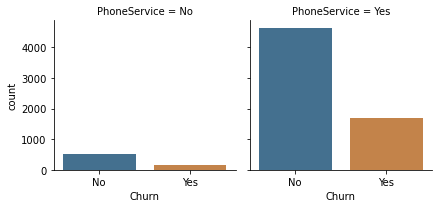

There is no association between PhoneService and  Churn
 
 


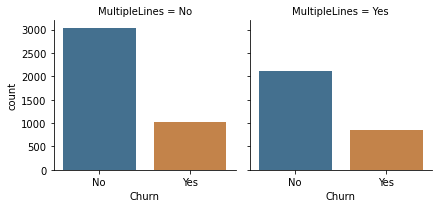

There is association between MultipleLines and  Churn
The strength of the assocation is 0.04
 
 


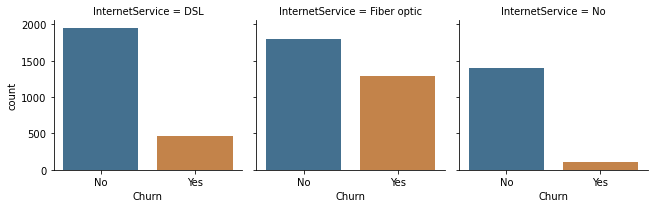

There is association between InternetService and  Churn
The strength of the assocation is 0.32
 
 


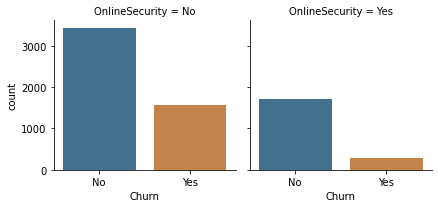

There is association between OnlineSecurity and  Churn
The strength of the assocation is 0.17
 
 


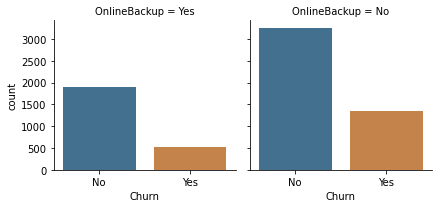

There is association between OnlineBackup and  Churn
The strength of the assocation is 0.08
 
 


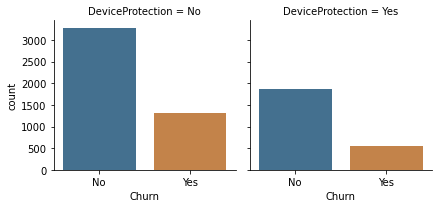

There is association between DeviceProtection and  Churn
The strength of the assocation is 0.07
 
 


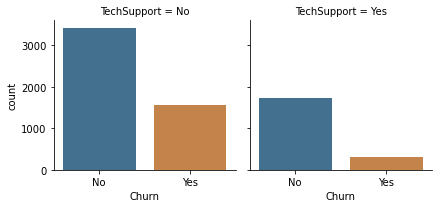

There is association between TechSupport and  Churn
The strength of the assocation is 0.16
 
 


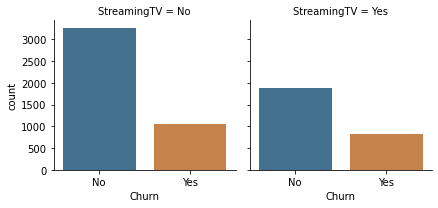

There is association between StreamingTV and  Churn
The strength of the assocation is 0.06
 
 


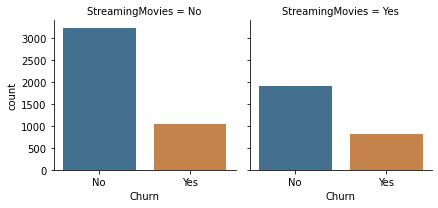

There is association between StreamingMovies and  Churn
The strength of the assocation is 0.06
 
 


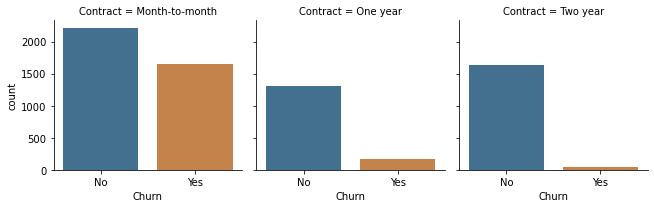

There is association between Contract and  Churn
The strength of the assocation is 0.41
 
 


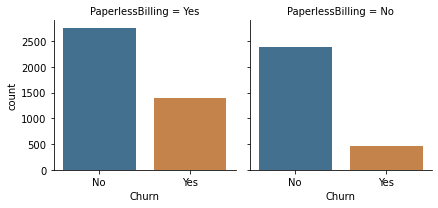

There is association between PaperlessBilling and  Churn
The strength of the assocation is 0.19
 
 


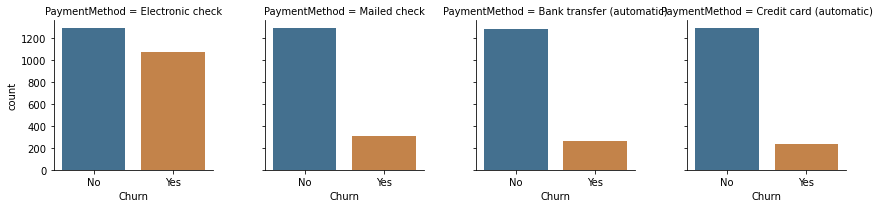

There is association between PaymentMethod and  Churn
The strength of the assocation is 0.3
 
 


In [15]:
cramers_v_df=[]
columns_list=churn_data.select_dtypes(include=['object']).columns.to_list()
for i in columns_list:
    if(i != 'Churn'):
        col,cramerv,p=categorical_association(churn_data,str(i),'Churn')
        information_gain=info_gain.info_gain(churn_data['Churn'],churn_data[i])
        cramers_v_df.append([col,round(cramerv,2),p,round(information_gain,4)])

In [16]:
print('The CramerV correlation coefficient for the nominal variables are')
pd.DataFrame(cramers_v_df,columns=['variable','cramerV','p-value','Information_Gain']).sort_values(by=['cramerV'],ascending=False)

The CramerV correlation coefficient for the nominal variables are


,variable,cramerV,p-value,Information_Gain
13,Contract,0.41,0.0000,0.0982
6,InternetService,0.32,0.0000,0.0554
15,PaymentMethod,0.30,0.0000,0.0444
14,PaperlessBilling,0.19,0.0000,0.0191
7,OnlineSecurity,0.17,0.0000,0.0159
3,Dependents,0.16,0.0000,0.0143
10,TechSupport,0.16,0.0000,0.0146
1,SeniorCitizen,0.15,0.0000,0.0105
2,Partner,0.15,0.0000,0.0114
8,OnlineBackup,0.08,0.0000,0.0035


### Highlights from exploratory data analysis for the categorical variables

    * From the Chi-square test of independence, we can say except for the gender and phone 
      service, other categorical variables are associated with the Target variable Churn
      
    * The Cramer's V coefficient has been used to measure the association between the nominal 
      variables and the categorical target variables
      
       * Out of all the variables, contract type has the strongest association with coefficient
         of 0.41. If a customer is on month-to-month, the chances of his churn are pretty high
           
       * The next variable is InternetService with coefficient of 0.32,followed by Payment method.
             
          - If the internet service is Fiber Optic, the chances of their churn is High
             
          - If the payment method is electronic payment, the chances of them churning out 
            is high when compared to the customers making payment through other modes ofpayment

### Variables to drop after preliminary EDA

    * Insiginifcant variables (p value > 0.05 and also when there is no Information Gain
    * Variables with very low cramer's V correlation(<0.10) with the target 

In [17]:
churn_data.drop(columns=['gender','PhoneService','MultipleLines','StreamingMovies', \
                         'StreamingTV','DeviceProtection',
                        'OnlineBackup'],inplace=True)

### Numeric Variables

#### Checking the  associations among the numerical predictors

    * Correlation Analysis


#### Checking the  associations between the target and the numerical predictors

    * Point-Biserial Correlation

        * The Point-Biserial Correlation Coefficient is a correlation measure of the strength of
          association between a continuous-level variable (ratio or interval data) and a binary 
          variable. Binary variables are variables of nominal scale with only two values.

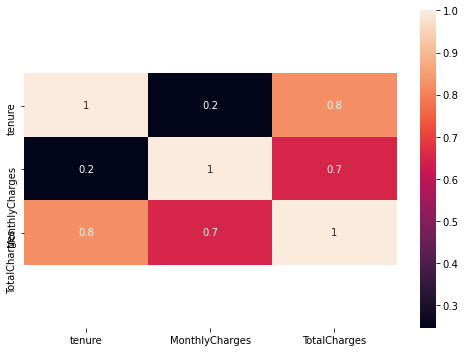

In [18]:
plt.figure(figsize = (7,5))
ax=sns.heatmap(numeric_cols_data.corr(), annot=True,fmt='.1g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1, top -1)
plt.tight_layout()

### Insights from Correlation Analysis

    * Total Charges and Monthly charges have a correlation of 0.7
    * Total Charges and Tenure have a correlation of 0.8
       
      Variables are suffering from multi-collinearity 
      
### Why is Multicollinearity a Potential Problem?

      A key goal of regression analysis is to isolate the relationship between each 
      independent variable and the dependent variable. The interpretation of a regression 
      coefficient is that it represents the mean change in the dependent variable for each 
      1 unit change in an independent variable when you hold all of the other independent 
      variables constant. That last portion is crucial for our discussion about multicollinearity.
      
      The idea is that you can change the value of one independent variable and not the 
      others. However, when independent variables are correlated, it indicates that changes 
      in one variable are associated with shifts in another variable. The stronger the 
      correlation, the more difficult it is to change one variable without changing another. 
      It becomes difficult for the model to estimate the relationship between each 
      independent variable and the dependent variable independently because the independent
      variables tend to change in unison.
      
      *Reason : Total Charges = (Monthly Charges * Tenure) + Noise(AdditionalCharges)

In [19]:
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

print(color.BOLD+color.RED+'The Variance Inflation Factor for the selected variables are ')
checkVIF(churn_data[['tenure','MonthlyCharges','TotalCharges']])

The Variance Inflation Factor for the selected variables are 


,Features,VIF
2,TotalCharges,8.08
0,tenure,6.33
1,MonthlyCharges,3.36


####  Association between the Continuous Variable and Target 

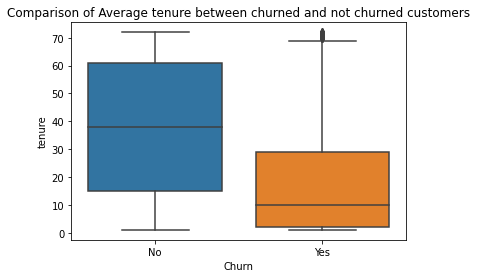

There is association between Churn and  tenure
The strength of relation is -0.35


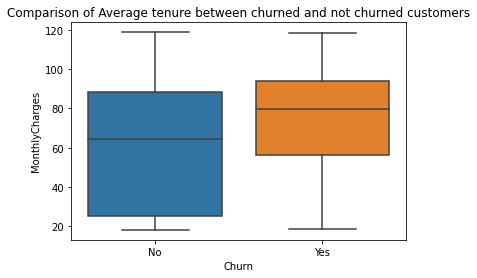

There is association between Churn and  MonthlyCharges
The strength of relation is 0.19


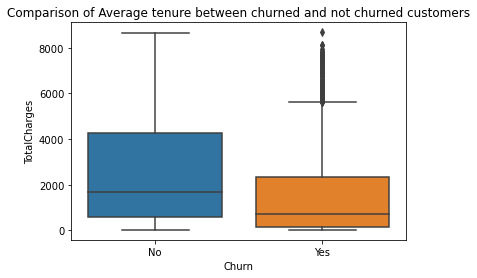

There is association between Churn and  TotalCharges
The strength of relation is -0.2


In [20]:
#Checkicg for the association for continous variables
continous_association(churn_data,'Churn','tenure')
continous_association(churn_data,'Churn','MonthlyCharges')
continous_association(churn_data,'Churn','TotalCharges')

### Insights from the correlation analysis and statistical tests

    * All three variables are highly correlated with each other
    * The strength of association between tenure and the target is the largest.
    
       I'm considering only tenure out of the three variables

In [21]:
churn_data.drop(columns=['TotalCharges','MonthlyCharges'],inplace=True)

In [22]:
print(color.BOLD+'The Descriptive statistics of tenure is ')
churn_data['tenure'].describe()

The Descriptive statistics of tenure is 


count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [23]:
#converting the column tenure from months into years
churn_data['tenure_bin']=pd.cut(churn_data['tenure'], [0, 12,24,36,48,60,72],
       labels=['0_12', '12_24', '24_36','36_48','48_60','60_72'])
churn_data['tenure_bin'].astype('object')

#dropping tenure column
churn_data.drop(columns=['tenure'],inplace=True)

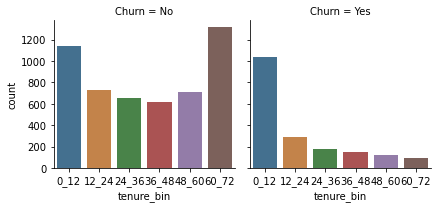

There is association between Churn and  tenure_bin
The strength of the assocation is 0.35
 
 


('Churn', 0.35, 0.0)

In [24]:
categorical_association(churn_data,'Churn','tenure_bin')

### 4. Variable Transformations

In [25]:
print(color.BOLD+color.GREEN+'The skewness of the variables are ')
print('')
skewness=churn_data.skew(axis = 0, skipna = True,numeric_only=True).sort_values(ascending=False) 
print(skewness)

The skewness of the variables are 

Series([], dtype: float64)


### 5. Dummy Variables Creation

In [26]:
Churn_predictors_cat=dummy_variables_creation(churn_data)
Churn_predictors_cat.drop(columns=['Churn_Yes','Churn_No'],inplace=True)

The variables that are dropped as part of dummy creation
['SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'tenure_bin']


In [27]:
#separating target variable from the predictors 
churn_target=churn_data.replace({'Churn':{'No':0,'Yes':1}})['Churn']
churn_target=churn_target.astype('int')

## SMOTE Sampling 

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [28]:
# transform the dataset
from imblearn.combine import SMOTETomek
from collections import Counter
oversample = SMOTETomek()
print('Before Sampling')
print(Counter(churn_target))
Churn_predictors_os, Churn_Target_os = oversample.fit_resample(Churn_predictors_cat,churn_target)
print('**************************')
print('After Sampling')
print(Counter(Churn_Target_os))

Using TensorFlow backend.


Before Sampling
Counter({0: 5163, 1: 1869})
**************************
After Sampling
Counter({0: 5152, 1: 5152})


### Splitting the dataset into training and test 

In [29]:
# create training and testing data set (70-30)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Churn_predictors_os, \
                                                    Churn_Target_os, \
                                                    test_size=0.3,
                                                    random_state=12345)

### Building a Logistic Regression model to select important features

In [30]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='liblinear',penalty='l1')

#Recursive feature elimination to further eliminate any redundant varibles
rfe = RFE(logreg,)
rfe.fit(X_train, y_train)

#Extracting the most important features

important_variables = rfe.get_support(1)
print(color.BOLD+'The variables selected are ')
print(' ')
print(X_train[X_train.columns[important_variables]].columns.tolist())

The variables selected are 
 
['InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_No', 'TechSupport_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure_bin_0_12']


### Subsetting the data with the important features

In [31]:
X_train_selected= X_train[X_train.columns[important_variables]]
X_test_selected= X_test[X_test.columns[important_variables]]

### Fitting the model in statmodels using the important features for better output display

In [70]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

#adding a constant
X_train_selected=X = sm.add_constant(X_train_selected)

#fitting a model
logit_model=sm.Logit(y_train,X_train_selected)
logistic_fit=logit_model.fit(method='bfgs',penalty='l1')
print(logistic_fit.summary2())

         Current function value: 0.427751
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
                                     Results: Logit
Model:                      Logit                    Pseudo R-squared:         0.383    
Dependent Variable:         Churn                    AIC:                      6199.8820
Date:                       2020-04-09 10:43         BIC:                      6303.1345
No. Observations:           7212                     Log-Likelihood:           -3084.9  
Df Model:                   14                       LL-Null:                  -4998.9  
Df Residuals:               7197                     LLR p-value:              0.0000   
Converged:                  0.0000                   Scale:                    1.0000   
----------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------

c:\users\harish patlolla\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:511: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


In [71]:
oddsratio=pd.DataFrame(np.exp(logistic_fit.params)).reset_index().rename(columns={'index':'variable',
                                                                  0:'oddsratio'})

print(round(oddsratio,2).sort_values(by=['oddsratio'],ascending=False))

                                   variable  oddsratio
5                   Contract_Month-to-month       8.56
2               InternetService_Fiber optic       3.87
14                          tenure_bin_0_12       2.94
12           PaymentMethod_Electronic check       2.23
9                      PaperlessBilling_Yes       2.21
4                            TechSupport_No       1.73
13               PaymentMethod_Mailed check       1.54
6                         Contract_One year       1.53
1                       InternetService_DSL       1.47
3                         OnlineSecurity_No       1.36
10  PaymentMethod_Bank transfer (automatic)       1.36
8                       PaperlessBilling_No       1.33
11    PaymentMethod_Credit card (automatic)       1.32
7                         Contract_Two year       1.24
0                                     const       0.01


### Testing the logistic regression model on the train and test data

In [72]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer

def accuracy_metrics(predict,actual):

    #confusion matrix
    conf_matrix_train = confusion_matrix(predict.round(),actual)
    fig, ax = plt.subplots(figsize=(5,4))
    heatmap=sns.heatmap(conf_matrix_train,annot=True,fmt="d",
                    xticklabels=['Non Churn', 'Churn'],yticklabels=['Non Churn', 'Churn'])
    ax.set_ylim([0,2])
    plt.ylabel('Actual ')
    plt.xlabel('Predicted ')
    plt.show()

    #F-1score, accuracy, precision,recall
    print('Classification Report is \n')
    print(classification_report(predict.round(),actual))

    #Area under the curve (AUC)
    model_roc_auc = roc_auc_score(predict.round(),actual) 
    print ("Area under curve : ",round(model_roc_auc,3),"\n")

c:\users\harish patlolla\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


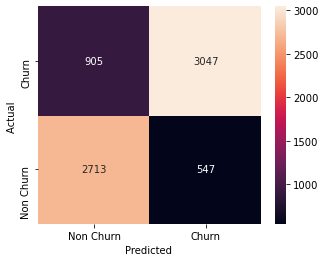

Classification Report is 

              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79      3260
         1.0       0.85      0.77      0.81      3952

    accuracy                           0.80      7212
   macro avg       0.80      0.80      0.80      7212
weighted avg       0.80      0.80      0.80      7212

Area under curve :  0.802 

##################################################
 Test data accuracy metrics are 


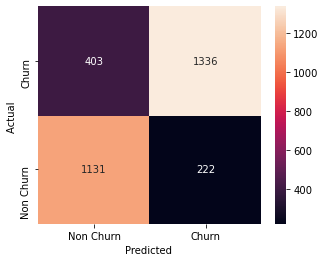

Classification Report is 

              precision    recall  f1-score   support

         0.0       0.74      0.84      0.78      1353
         1.0       0.86      0.77      0.81      1739

    accuracy                           0.80      3092
   macro avg       0.80      0.80      0.80      3092
weighted avg       0.80      0.80      0.80      3092

Area under curve :  0.802 



In [73]:
#fitting logistic model on the train dataset
y_pred_train=logistic_fit.predict(X_train_selected)

#fitting logistic model on the test dataset
X_test_selected=X = sm.add_constant(X_test_selected)
y_pred_test=logistic_fit.predict(X_test_selected)

#training dataset
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

# Decision Trees

    For ensembles of decision trees, feature selection is generally not that important. 
    During the induction of decision trees, the optimal feature is selected to split the
    data based on metrics like information gain, so if you have some non-informative
    features, they simply won't be selected
    
    Decision trees are not stable. With the addition of even few observations, the complete 
    structure of the tree changes

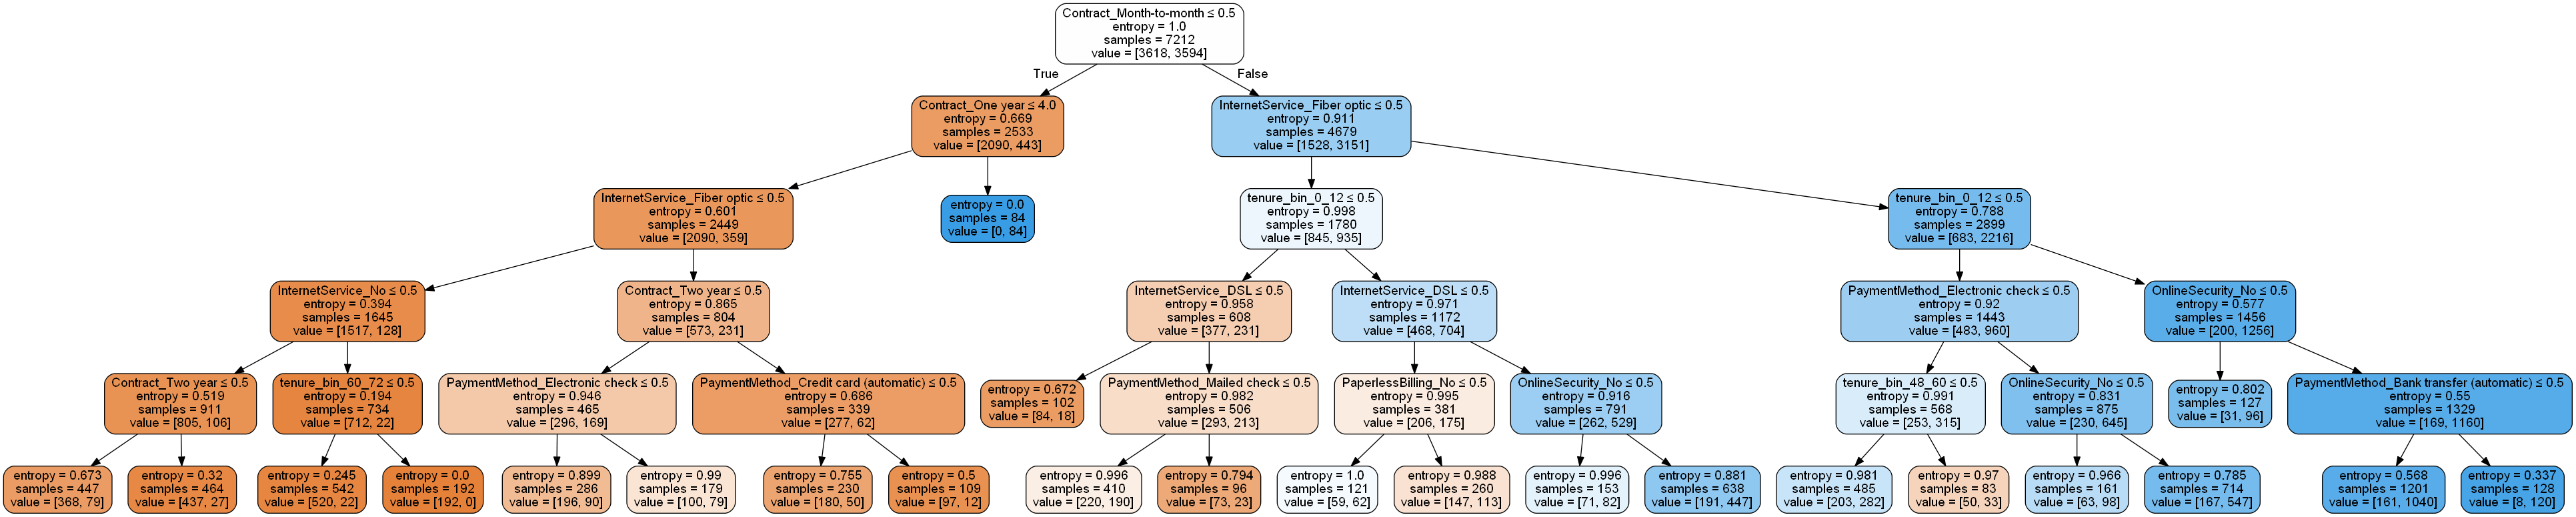

In [80]:
from sklearn.tree import DecisionTreeClassifier
#creating an instance for a decision tree classifier
#using information gain as the criteria to choose the most important variable
dec_tree = DecisionTreeClassifier(criterion='entropy',\
                                  max_depth=5,
                                 min_samples_split=100,
                                 min_samples_leaf=80)

#Fitting a decision tree on the training dataset
dec_tree.fit(X_train, y_train)

#Visualizing the decision tree

col_names = list(X_train.columns.values)
dot_data = StringIO()
tree.export_graphviz(dec_tree, out_file=dot_data,
                     feature_names=col_names,
                     filled=True,
                     rounded=True,
                     special_characters=True)

graph = pydotplus.graphviz.graph_from_dot_data(dot_data.getvalue())
display(Image(graph.create_png()))

 Train data accuracy metrics are 


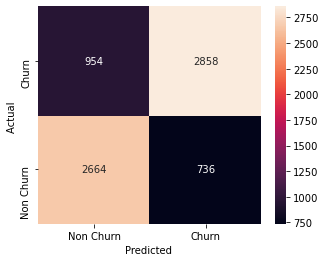

Classification Report is 

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3400
           1       0.80      0.75      0.77      3812

    accuracy                           0.77      7212
   macro avg       0.77      0.77      0.77      7212
weighted avg       0.77      0.77      0.77      7212

Area under curve :  0.767 

##################################################
 Test data accuracy metrics are 


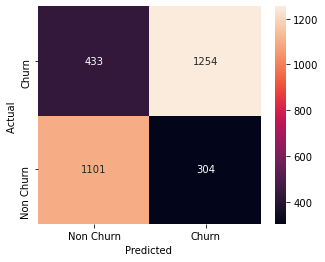

Classification Report is 

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      1405
           1       0.80      0.74      0.77      1687

    accuracy                           0.76      3092
   macro avg       0.76      0.76      0.76      3092
weighted avg       0.77      0.76      0.76      3092

Area under curve :  0.763 



In [82]:
#fitting decision tree on the train dataset
y_pred_train=dec_tree.predict(X_train)

#fitting logistic model on the test dataset
y_pred_test=dec_tree.predict(X_test)

#training dataset
print(' Train data accuracy metrics are ')
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

# Bagging Models
        
### Bagging Classifier
       
     Bootstrap aggregating, also called bagging (from bootstrap aggregating), is a 
     machine learning ensemble meta-algorithm designed to improve the stability and 
     accuracy of machine learning algorithms used in statistical classification and regression
     It  reduces variance and helps to avoid overfitting
           
     - The number of trees won't overfit the model since it averages the predictions
     
#### Disadvantages
    
     - The trees have high correlation 
       since the important predictors will be the root nodes in most of the trees


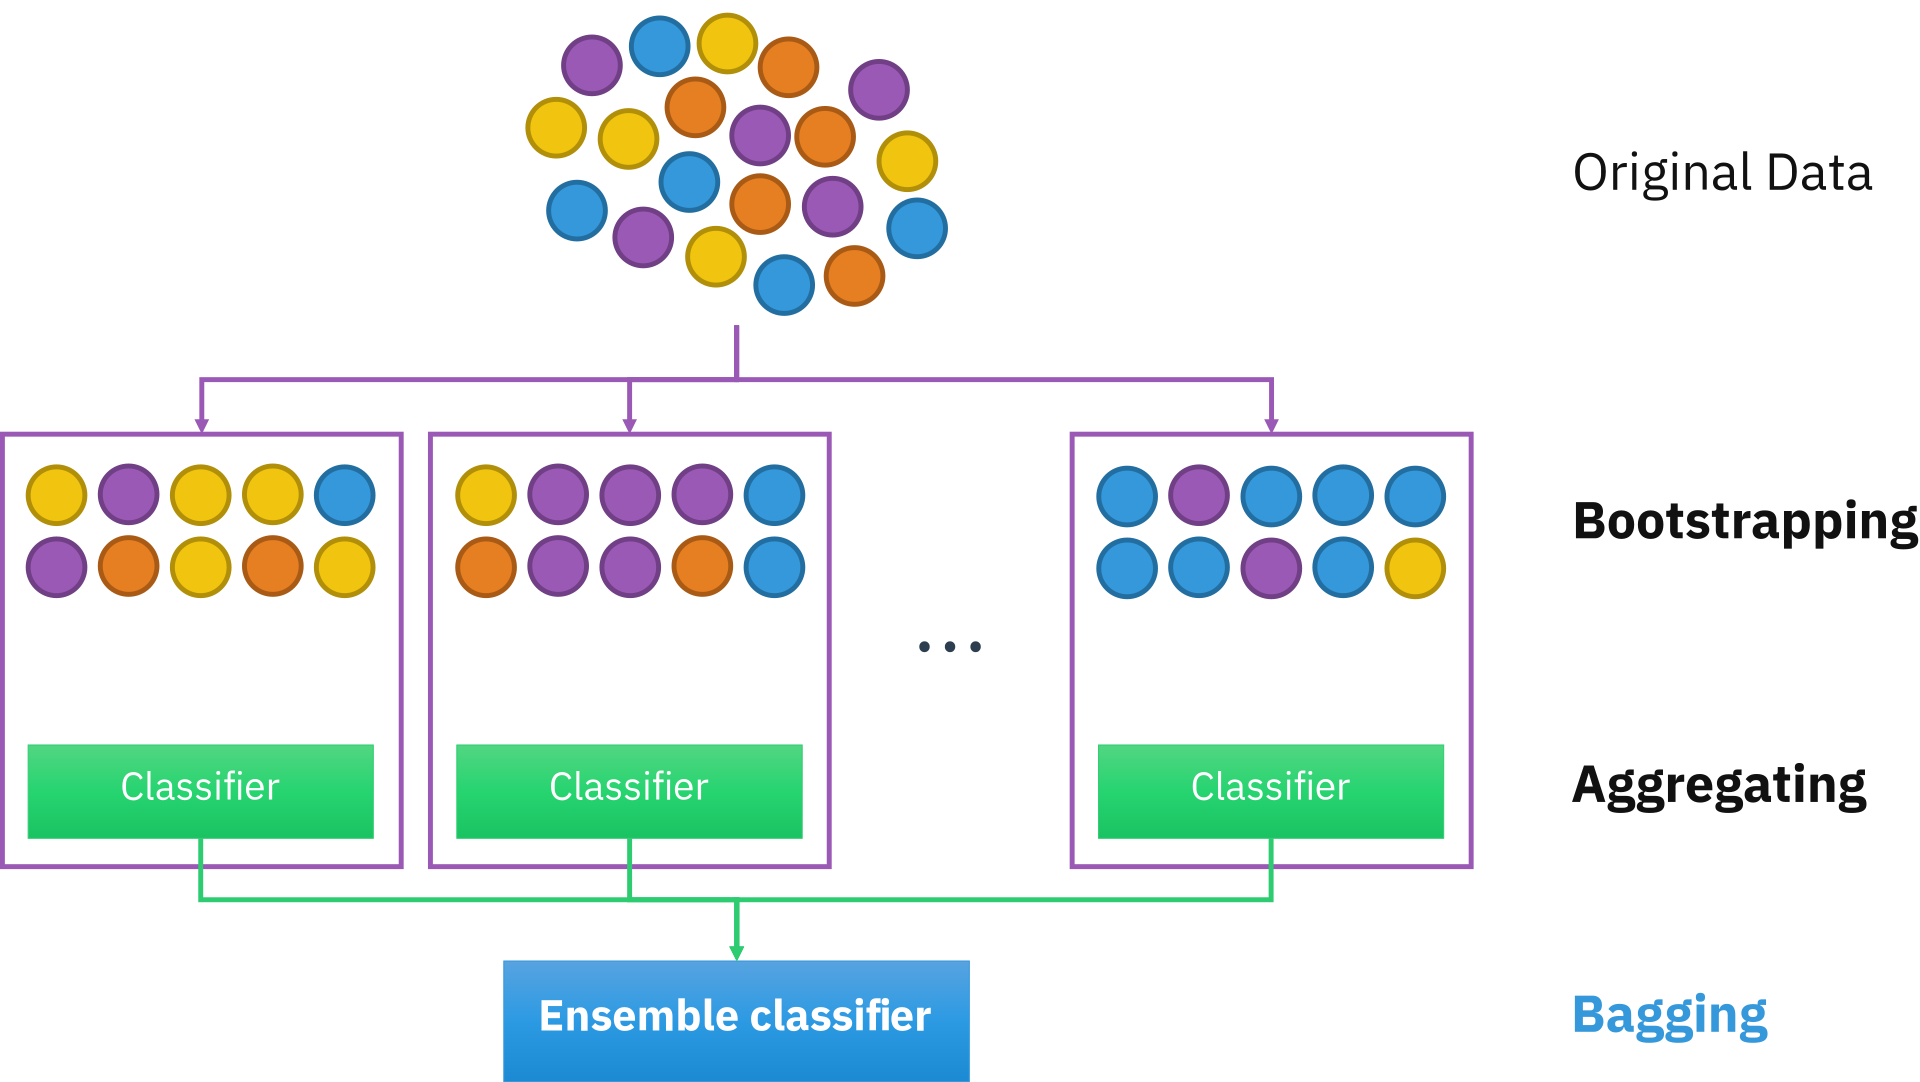

In [85]:
Image(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\Telecom Churn Analysis\Bagging.png")

In [87]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

# Instantiate decisiontree
decisiontree = DecisionTreeClassifier(criterion='entropy',
                                      splitter="random",
                                      random_state=1,
                                      max_depth=3)

number_of_trees=50

# Instantiate bagging classifier
bc = BaggingClassifier(base_estimator=decisiontree, 
                       n_estimators=number_of_trees, 
                       max_samples=0.7, # percentage of data for bootstrapping
                       random_state=1,
                       oob_score=bool)


BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='entropy',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=1,
   

 Train data accuracy metrics are 


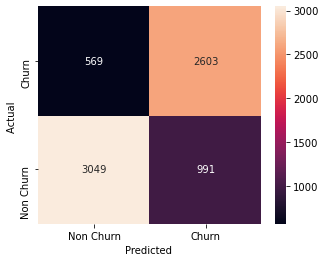

Classification Report is 

              precision    recall  f1-score   support

           0       0.84      0.75      0.80      4040
           1       0.72      0.82      0.77      3172

    accuracy                           0.78      7212
   macro avg       0.78      0.79      0.78      7212
weighted avg       0.79      0.78      0.78      7212

Area under curve :  0.788 

##################################################
 Test data accuracy metrics are 


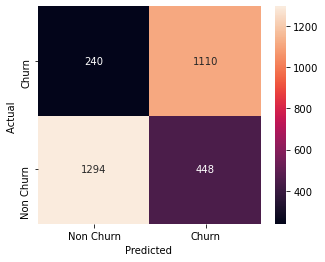

Classification Report is 

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1742
           1       0.71      0.82      0.76      1350

    accuracy                           0.78      3092
   macro avg       0.78      0.78      0.78      3092
weighted avg       0.79      0.78      0.78      3092

Area under curve :  0.783 



In [88]:
#fitting decision tree on the train dataset
y_pred_train=bc.predict(X_train)

#fitting logistic model on the test dataset
y_pred_test=bc.predict(X_test)

print(' Train data accuracy metrics are ')
#training dataset
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

## Random Forest

    Random Forests “cannot overfit” the data. It is certainly true that increasing B 
    [the number of trees in the ensemble] does not cause the random forest sequence to 
    overfit. However, this limit can overfit the data; the average of fully grown trees 
    can result in too rich a model, and incur unnecessary variance. Segal (2004) demonstrates
    small gains in performance by controlling the depths of the individual trees grown in
    random forests. Our experience is that using full-grown trees seldom costs much, 
    and results in one less tuning parameter. Stated another way, for a fixed
    hyperparameter configuration, increasing the number of trees cannot overfit the data; 
    however, the other hyperparameters might be a source of overfit.

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
 
     * Evaluating multiple combinations of paramaters using Randomized SearchCV

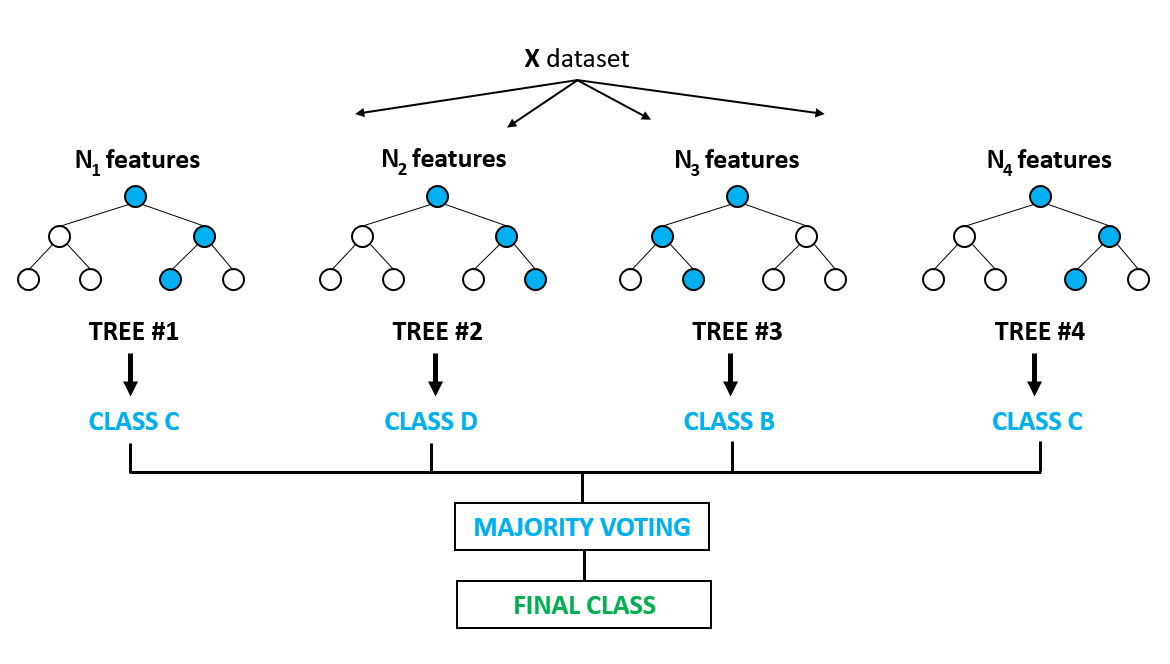

In [94]:
Image(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\Telecom Churn Analysis\randomforest.png")

### Defining the set of hyperparameters to try & choose

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
#starting from 200 and ending to 2000 with samples equal to num=100
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

### Using the random grid to search for best hyperparameters

In [93]:
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3, 
                               verbose=2,
                               random_state=42, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.2min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

###  Best Hyper Parameters for Random Forest

In [95]:
print('The best hyper parameters for random forest are')
rf_random.best_params_

The best hyper parameters for random forest are


{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

### Initializing and fitting a Random Forest model with best hyper parameters

In [98]:
# random forest model creation
rfc = RandomForestClassifier(n_estimators=1000, 
                             max_depth=6,
                             min_samples_split=10,
                             max_features = 'auto',
                            bootstrap = True,
                            criterion='entropy',
                            oob_score=True)

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [107]:
# Extract feature importances
feature_importance_random_Forest = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': rfc.feature_importances_})
feature_importance_random_Forest.sort_values(by=['importance'],ascending=False,inplace=True)

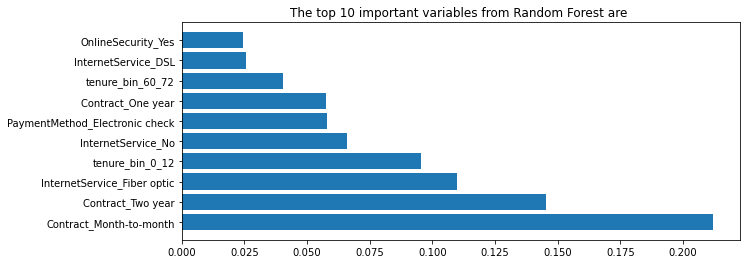

In [123]:
plt.figure(figsize=(10,4))
plt.barh(feature_importance_random_Forest['feature'].iloc[:10,],width=feature_importance_random_Forest['importance'].iloc[:10,])
plt.title('The top 10 important variables from Random Forest are ')
plt.show()

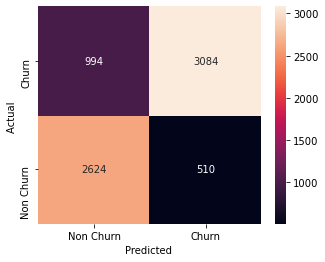

Classification Report is 

              precision    recall  f1-score   support

           0       0.73      0.84      0.78      3134
           1       0.86      0.76      0.80      4078

    accuracy                           0.79      7212
   macro avg       0.79      0.80      0.79      7212
weighted avg       0.80      0.79      0.79      7212

Area under curve :  0.797 

##################################################
 Test data accuracy metrics are 


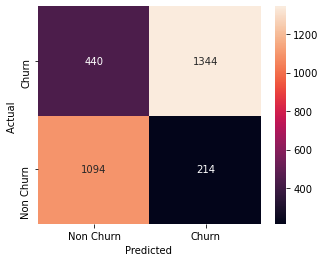

Classification Report is 

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1308
           1       0.86      0.75      0.80      1784

    accuracy                           0.79      3092
   macro avg       0.79      0.79      0.79      3092
weighted avg       0.80      0.79      0.79      3092

Area under curve :  0.795 



In [124]:
#fitting decision tree on the train dataset
y_pred_train=rfc.predict(X_train)

#fitting logistic model on the test dataset
y_pred_test=rfc.predict(X_test)

#training dataset
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

## Gradient Boosting

    The term 'Boosting' refers to a family of algorithms which converts weak learner to 
    strong learners. Boosting is an ensemble method for improving the model predictions of
    any given learning algorithm. The idea of boosting is to train weak learners sequentially, 
    each trying to correct its predecessor. 
    
    Boosting algorithms are meant to reduce bias not variance. 
    The two types of boosting used are

        * AdaBoost 
        * Gradient Boosting

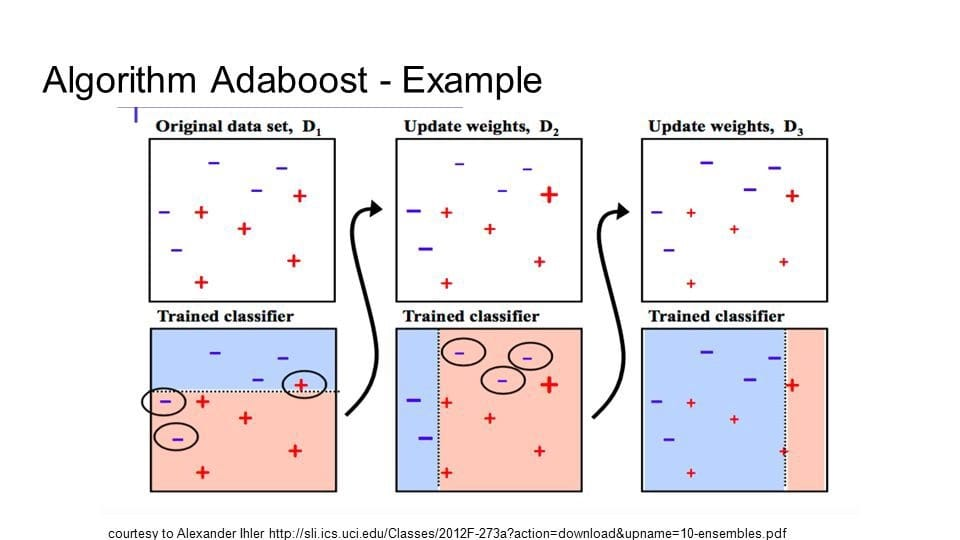

In [125]:
Image(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\Telecom Churn Analysis\Adaboost.jpg")

In [126]:
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

#learning rate is the hyperparameter
lr_list = [0.05, 0.075,0.01,0.001, 0.1, 0.25, 0.5, 0.75, 1]

#decision tree with depth=1 are referred as decision stumps
decision_tree=DecisionTreeClassifier(criterion='entropy',max_depth=1)

hyperparameters_table=[]
#choosing hyper parameters (learning rate)
for learning_rate in lr_list:
    adaboost_clf = AdaBoostClassifier(
                                      learning_rate=learning_rate, 
                                      base_estimator=decision_tree, 
                                      random_state=0)
    adaboost_clf.fit(X_train, y_train)
    accuracy_training=round(adaboost_clf.score(X_train, y_train),2)
    accuracy_validation=round(adaboost_clf.score(X_test, y_test),2)
    hyperparameters_table.append([learning_rate,accuracy_training,accuracy_validation])


In [127]:
hyper_param_df=pd.DataFrame(hyperparameters_table).reset_index().rename(columns={0:'learning_rate',
                                                                  1:'training_accuracy',
                                                                 2:'validaton_accuracy'})

hyper_param_df

,index,learning_rate,training_accuracy,validaton_accuracy
0,0,0.050,0.76,0.76
1,1,0.075,0.77,0.77
2,2,0.010,0.73,0.72
3,3,0.001,0.73,0.72
4,4,0.100,0.79,0.79
5,5,0.250,0.82,0.82
6,6,0.500,0.83,0.82
7,7,0.750,0.83,0.83
8,8,1.000,0.84,0.83


### choosing best learning rate and fitting the model

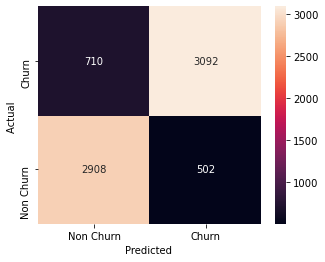

Classification Report is 

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      3410
           1       0.86      0.81      0.84      3802

    accuracy                           0.83      7212
   macro avg       0.83      0.83      0.83      7212
weighted avg       0.83      0.83      0.83      7212

Area under curve :  0.833 

##################################################
 Test data accuracy metrics are 


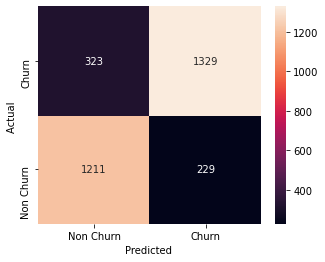

Classification Report is 

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1440
           1       0.85      0.80      0.83      1652

    accuracy                           0.82      3092
   macro avg       0.82      0.82      0.82      3092
weighted avg       0.82      0.82      0.82      3092

Area under curve :  0.823 



In [128]:
adaboost_classfier_choosen=AdaBoostClassifier(
                                      learning_rate=0.5, 
                                      base_estimator=decision_tree, 
                                      random_state=0)

adaboost_classfier_choosen.fit(X_train,y_train)

#fitting decision tree on the train dataset
y_pred_train=adaboost_classfier_choosen.predict(X_train)

#fitting logistic model on the test dataset
y_pred_test=adaboost_classfier_choosen.predict(X_test)

#training dataset
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

### Gradient Boosting

In [129]:
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier

lr_list = [0.05, 0.075,0.01,0.001,0.0001, 0.1, 0.25, 0.5, 0.75, 1]

hyperparameters_table=[]
for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)
    accuracy_training=round(gb_clf.score(X_train, y_train),2)
    accuracy_validation=round(gb_clf.score(X_test, y_test),2)
    hyperparameters_table.append([learning_rate,accuracy_training,accuracy_validation])

hyper_param_df=pd.DataFrame(hyperparameters_table).reset_index().rename(columns={0:'learning_rate',
                                                                  1:'training_accuracy',
                                                                 2:'validaton_accuracy'})

hyper_param_df

,index,learning_rate,training_accuracy,validaton_accuracy
0,0,0.0500,0.76,0.76
1,1,0.0750,0.76,0.76
2,2,0.0100,0.75,0.76
3,3,0.0010,0.72,0.71
4,4,0.0001,0.50,0.50
5,5,0.1000,0.77,0.77
6,6,0.2500,0.79,0.79
7,7,0.5000,0.80,0.80
8,8,0.7500,0.81,0.80
9,9,1.0000,0.81,0.79


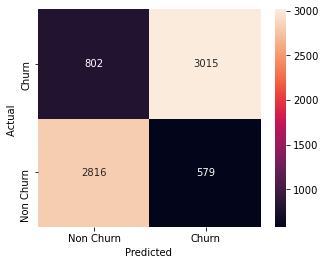

Classification Report is 

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      3395
           1       0.84      0.79      0.81      3817

    accuracy                           0.81      7212
   macro avg       0.81      0.81      0.81      7212
weighted avg       0.81      0.81      0.81      7212

Area under curve :  0.81 

##################################################
 Test data accuracy metrics are 


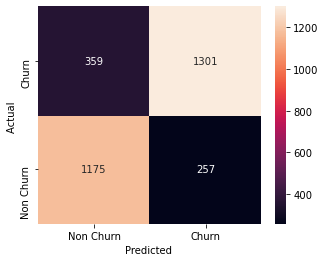

Classification Report is 

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1432
           1       0.84      0.78      0.81      1660

    accuracy                           0.80      3092
   macro avg       0.80      0.80      0.80      3092
weighted avg       0.80      0.80      0.80      3092

Area under curve :  0.802 



In [132]:
gb_clf = GradientBoostingClassifier(n_estimators=20, 
                                    learning_rate=0.75, 
                                    max_features=2, 
                                    max_depth=2,
                                    random_state=0)
 

gb_clf.fit(X_train, y_train)

#fitting decision tree on the train dataset
y_pred_train=gb_clf.predict(X_train)

#fitting logistic model on the test dataset
y_pred_test=gb_clf.predict(X_test)

#training dataset
accuracy_metrics(y_pred_train,y_train)

#testing dataset
print('##################################################')
print(' Test data accuracy metrics are ')
accuracy_metrics(y_pred_test,y_test)

### Comparison of classification models
    
    AUC provides an aggregate measure of performance across all possible classification thresholds

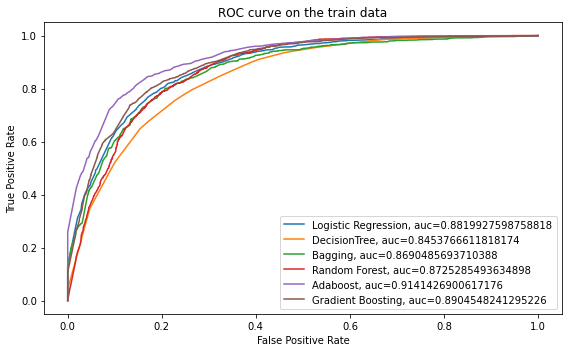

In [183]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5),num=1).clf()
#Logistic Regression
y_pred_train = np.array(logistic_fit.predict(X_train_selected))
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train,  y_pred_train)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.legend(loc=4)

#Decision tree
y_pred_train= dec_tree.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train, y_pred_train)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))
plt.legend(loc=4)

#Bagging Classifier
y_pred_train= bc.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train, y_pred_train)
plt.plot(fpr,tpr,label="Bagging, auc="+str(auc))
plt.legend(loc=4)
         

#Random Forest Classifier
y_pred_train= rfc.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train, y_pred_train)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)

#AdaBoost Classifier
y_pred_train= adaboost_classfier_choosen.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train, y_pred_train)
plt.plot(fpr,tpr,label="Adaboost, auc="+str(auc))
plt.legend(loc=4)
         
#Gradient Boosting Classifier
y_pred_train= gb_clf.predict_proba(X_train)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_train,  y_pred_train)
auc = metrics.roc_auc_score(y_train, y_pred_train)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the train data')
plt.tight_layout()

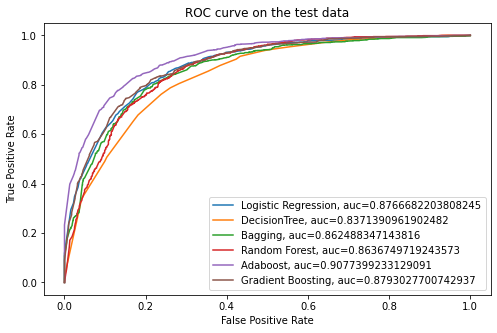

In [184]:

plt.figure(figsize=(8,5),num=0).clf()
#Logistic Regression
y_pred_test = np.array(logistic_fit.predict(X_test_selected))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))
plt.legend(loc=4)

#Decision tree
y_pred_test = dec_tree.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))
plt.legend(loc=4)

#Bagging Classifier
y_pred_test = bc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Bagging, auc="+str(auc))
plt.legend(loc=4)
         

#Random Forest Classifier
y_pred_test = rfc.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Random Forest, auc="+str(auc))
plt.legend(loc=4)

#AdaBoost Classifier
y_pred_test = adaboost_classfier_choosen.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Adaboost, auc="+str(auc))
plt.legend(loc=4)
         
#Gradient Boosting Classifier
y_pred_test = gb_clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_test)
auc = metrics.roc_auc_score(y_test, y_pred_test)
plt.plot(fpr,tpr,label="Gradient Boosting, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on the test data')
plt.show()

## AdaBoost Classifier is the winning model with 
            AUC(Train) as 0.915 
            AUC(Test)  as 0.907